In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

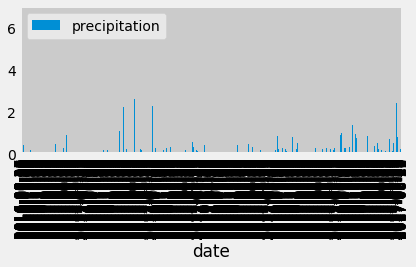

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Getting the last date recorded in the database
lastRecordedDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#Convert the date from string to a datetime type
lastRecordedDate = dt.datetime.strptime(lastRecordedDate[0],'%Y-%m-%d' )
#Going back 12 months before that date
yearBeforelastRecordedDate = lastRecordedDate  - relativedelta(months=+12)
#Now we have the dates to query between. Lets get the precipitation between those dates
precipitationData = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > yearBeforelastRecordedDate).all()
#Now we dump it into a Pandas dataframe
precipitationData_df = pd.DataFrame(precipitationData, columns=['date','precipitation']) 
#Dropping NaN values
precipitationData_df = precipitationData_df.dropna()
#Setting date as an index
precipitationData_df.set_index('date',inplace=True)
precipitationData_df.sort_values(by=['date'])
#Use Pandas Plotting with Matplotlib to plot the data
precipitationData_df.plot.bar()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [38]:
precipitationData_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [39]:
# Design a query to show how many stations are available in this dataset?
numberOfStations = session.query(Station).count()
numberOfStations

9

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
activeStations = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
activeStations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [151]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
theMostActiveStation = activeStations.first()
theMostActiveStationID = theMostActiveStation[0]
# querying the data for temps recorded by this station
theMostActiveStationTemps  = session.query(Measurement.tobs).\
filter(Measurement.station == theMostActiveStationID)
theMostActiveStationTemps.all()

theMostActiveStationTemps_df = pd.DataFrame(theMostActiveStationTemps.all(), columns=['temp']) 

theMostActiveStationTempSummary = [theMostActiveStationTemps_df.max(),theMostActiveStationTemps_df.min(),theMostActiveStationTemps_df.mean()]
theMostActiveStationTempSummary

[temp    85.0
 dtype: float64, temp    54.0
 dtype: float64, temp    71.663781
 dtype: float64]

In [123]:
theMostActiveStationTempsPastYear = session.query(Measurement.tobs).\
filter(Measurement.station == theMostActiveStationID).\
filter(Measurement.date>yearBeforelastRecordedDate).all()

theMostActiveStationTempsPastYear_df = pd.DataFrame(theMostActiveStationTempsPastYear , columns=['temps'])


,temps
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


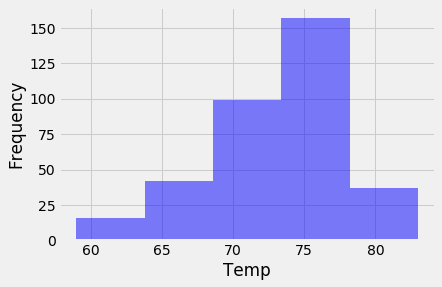

In [127]:
x =theMostActiveStationTempsPastYear_df['temps']
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('Temp')
plt.ylabel('Frequency')
plt.show()

In [135]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [142]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Convert the date from string to a datetime type
myTripStartDate = dt.datetime.strptime('2018-5-01','%Y-%m-%d' )
#Going back 12 months before that date
yearBeforeTripDateDate = myTripStartDate  - relativedelta(months=+12)
print(yearBeforeTripDateDate.strftime('%Y-%m-%d'))
 #TMIN, TAVE, and TMAX
temps_last_year = calc_temps( yearBeforeTripDateDate.strftime('%Y-%m-%d'), myTripStartDate.strftime('%Y-%m-%d'))


2017-05-01


[(65.0, 77.26923076923077, 87.0)]

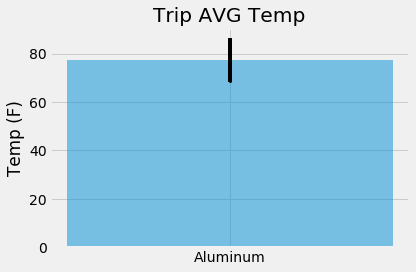

In [150]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Calculate the average
t_avg = 77.26923076923077


# Calculate the standard deviation
t_std = np.std(temps_last_year)

# Create lists for the plot

x_pos = np.arange(1)
CTEs = [t_avg]
error = [t_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=1)
ax.set_ylabel('Temp (F)')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Trip AVG Temp')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


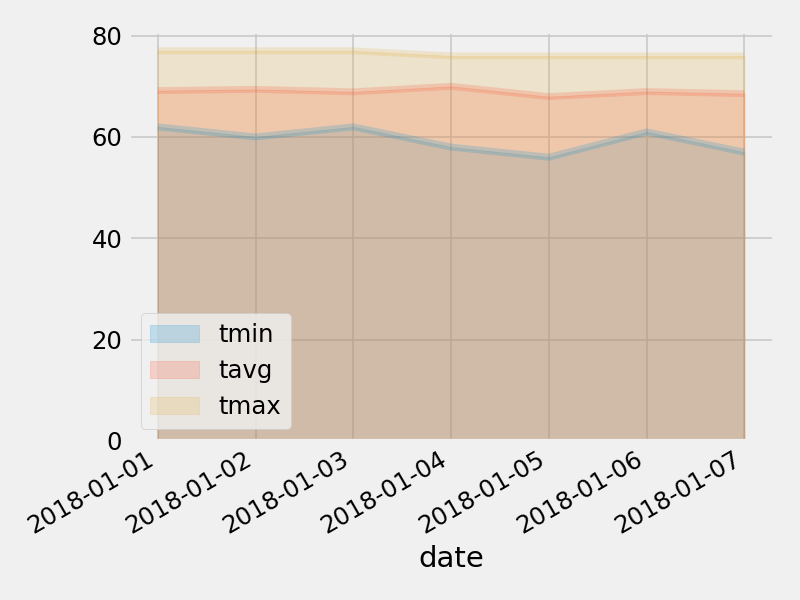

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
